In [51]:
import torch
import numpy as np
import cv2
from PIL import Image
from markdown_it.rules_inline import image
from seaborn import histplot
from transformers import SamProcessor, SamModel
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import display 
from matplotlib import pyplot as plt
from utils import pic2float, pic2int, pic2pil, sigmoid, swimg, display

MODEL_NAME = "facebook/sam-vit-base"
MODEL_NAME = "facebook/sam-vit-large"
MODEL_NAME = "facebook/sam-vit-huge"
DTYPE = torch.float16

In [2]:
def advanced_mask(logits, threshold=0.5, sigma=5, alpha=10):
    """
    Создает сложную маску с чёткими внутренними объектами и мягкими границами.
    
    :param logits: Логиты (numpy массив)
    :param threshold: Порог для бинаризации
    :param sigma: Параметр размытия для сглаживания границ
    :param alpha: Коэффициент крутизны для сигмоиды
    :return: Маска с плавными границами (numpy массив)
    """
    # 1. Бинаризация логитов
    sigmoid = 1 / (1 + np.exp(-logits))  # Преобразуем логиты в вероятности
    binary_mask = (sigmoid >= threshold).astype(np.float32)  # Бинарная маска

    # 2. Размытие бинарной маски для выделения границ
    blurred_binary = cv2.GaussianBlur(binary_mask, (0, 0), sigma)    

    # Нормализация размытой маски (для диапазона 0-1)
    blurred_binary = 0.25 - (blurred_binary - 0.5) ** 2 
    blurred_binary = cv2.GaussianBlur(blurred_binary, (0, 0), sigma)
    
    
    blurred_binary = blurred_binary / np.max(blurred_binary)
    blurred_binary = np.clip(blurred_binary, 0, 1)
    # print(blurred_binary.max(), blurred_binary.min())
    
    
    # return blurred_binary
    # 3. Применение размытой маски к сигмоиде
    alpha = 4
    soft_mask = 1 / (1 + np.exp(-alpha * (sigmoid - threshold)))  # Сигмоидная маска
    soft_mask = 1 * (sigmoid - 0.5) + 0.5 
    
    # binary_mask = cv2.GaussianBlur(binary_mask, (0, 0), 1)
    
    final_mask = soft_mask * blurred_binary + binary_mask * (1 - blurred_binary)
    final_mask = np.clip(final_mask, 0, 1)

    return final_mask

def mask_crop(image, mask):
    coords = np.where(mask)
    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()
    return image[y_min:y_max, x_min:x_max], mask[y_min:y_max, x_min:x_max]

def center(image, mask, shape = (512, 512), boudary = 0.2):
    h, w = shape
    bh = int(h * (1-boudary))
    bw = int(w * (1-boudary))
    obj_h, obj_w, _ = image.shape
    scale = min(bh / obj_h, bw / obj_w)
    new_h, new_w = int(obj_h * scale), int(obj_w * scale)
    # display(pic2pil(image))
    if scale < 1:
        algo = cv2.INTER_AREA
    else:
        algo = cv2.INTER_AREA
        algo = cv2.INTER_LINEAR 
        # algo = cv2.INTER_CUBIC
        # algo = cv2.INTER_LANCZOS4
    
    image = cv2.resize(image, (new_w, new_h), interpolation=algo)
    
    mask = cv2.resize(mask, (new_w, new_h))
    
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    
    new_mask = np.zeros((h, w, 3), dtype=np.float32)
    new_mask[top:top+new_h, left:left+new_w] = mask
    # 
    new_image = np.zeros((h, w, 3), dtype=np.float32)
    new_image[top:top+new_h, left:left+new_w] = image
        
    return new_image, new_mask
    # return image, mask
    

In [3]:
model = SamModel.from_pretrained(MODEL_NAME).to()

In [4]:
# import numpy as np
# import requests
# from PIL import Image
# import io
# 
# def pic2int(image):
#     if isinstance(image, torch.Tensor):
#         image = image.cpu().detach().numpy()
#         
#     if isinstance(image, Image.Image):
#         image = np.array(image)
#     
#     pic_max = image.max()
#     pic_min = image.min()
#     
#     if pic_min < 0 or pic_max > 255:
#         e = 1e-8
#         image = (image - pic_min + e) / (pic_max - pic_min + e)
#         pic_max = image.max()        
#         
#     if pic_max <= 1:
#         image = image * 255
#     
#     return image.astype('uint8')
# 
# def pic2float(image):
#     if isinstance(image, Image.Image):
#         image = np.array(image)
#     
#     pic_max = image.max()
#     pic_min = image.min()
#     
#     if pic_min < 0:
#         e = 1e-8
#         image = (image - pic_min + e) / (pic_max - pic_min + e)
#     elif pic_max > 1:
#         image = image / 255
#     else:
#         image = image.astype('float32')
#     
#     return image
#     
# def pic2pil(image):
#     if isinstance(image, torch.Tensor):
#         image = image.cpu().detach().numpy()
#     if isinstance(image, np.ndarray):
#         image = pic2int(image)
#         image = Image.fromarray(image)
#     return image
# 
# def swimg(image_arrays, server_url="http://127.0.0.1:9002/upload"):
#     """
#     Отправляет список numpy массивов на сервер Flask.
# 
#     :param image_arrays: Список numpy массивов (изображений)
#     :param server_url: URL сервера Flask    
#     """
#     
#     image_arrays = [pic2int(i) for i in image_arrays]
#     files = []
#     # print(image_arrays)
# 
#     for idx, array in enumerate(image_arrays):
#         # Преобразуем numpy массив в изображение (если нужно, приводим к uint8)
#         #if array.dtype != np.uint8:
#         #    array = (array * 255).astype(np.uint8)
#         
#         # Если изображение черно-белое, добавляем канал
#         if len(array.shape) == 2:  # Grayscale (H, W)
#             array = np.stack([array] * 3, axis=-1)  # Convert to (H, W, 3)
# 
#         # Преобразуем массив в изображение с помощью PIL
#         # print(array.shape, array.min(), array.max(), array.dtype)
#         image = Image.fromarray(array)
# 
#         # Сохраняем изображение в буфер памяти
#         buffer = io.BytesIO()
#         image.save(buffer, format="PNG")
#         buffer.seek(0)
# 
#         # Добавляем изображение в список файлов
#         files.append(('images', (f'image_{idx}.png', buffer, 'image/png')))
# 
#     # Отправляем POST-запрос с изображениями
#     response = requests.post(server_url, files=files)
# 
#     # Проверяем статус
#     if response.status_code == 200:
#         print(f"Successfully sent {len(image_arrays)} images to the server!")
#     else:
#         print(f"Failed to send images! Server response: {response.text}")
#         
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))
# 


In [5]:
class Predictor():
    def __init__(self, model=None, processor=None, device=None, model_name=MODEL_NAME, type=DTYPE):
        self.dtype = type

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device

        if model is None:
            model = SamModel.from_pretrained(model_name).to(self.dtype).to(self.device)
        if processor is None:
            processor = SamProcessor.from_pretrained(MODEL_NAME)

        self.model = model.to(self.device)
        self.processor = processor

    def predict(self, image, input_points=None):
        image = pic2float(image)

        if input_points is None:
            input_points = [[[image.shape[1] // 2, image.shape[0] // 2]]]

        inputs = self.processor(image, input_points=input_points, return_tensors="pt", do_rescale=False).to(self.dtype).to("cuda")

        with torch.inference_mode():
            outputs = self.model(**inputs)

        scores = outputs.iou_scores[0][0].cpu().detach().numpy().astype('float')
        masks = self.processor.image_processor.post_process_masks(
            outputs.pred_masks.cpu(),
            inputs["original_sizes"].cpu(),
            inputs["reshaped_input_sizes"].cpu(),
            binarize=False
        )[0][0].cpu().numpy().astype('float')

        return scores, masks

    @staticmethod
    def best_masks(scores, masks, n=4):

        best_masks = []
        best_masks_indexex = np.argsort(scores)[::-1][:n]

        for idx in best_masks_indexex:
            
            mask, score = masks[idx], scores[idx]
            mask = advanced_mask(mask)
            mask = np.stack([mask, mask, mask], axis=-1)
            best_masks.append(mask)
        return best_masks


In [14]:
#очистка видеопамяти
torch.cuda.empty_cache()

# сборщик мусора
import gc
gc.collect()

1060

In [6]:
sam_predictor = Predictor()

def sam_process(image, text=None):

    scores, masks = sam_predictor.predict(image)
    masks = sam_predictor.best_masks(scores, masks, 4)

    composes = []
    crop_masks = []

    for mask in masks:
        temp_image = image.copy()
        temp_image, mask = mask_crop(temp_image, mask)
        temp_image, mask = center(temp_image, mask)
        bg = np.ones_like(temp_image)
        compose = temp_image * mask + (1 - mask) * bg

        composes.append(compose)
        crop_masks.append(mask)
        
    return composes, crop_masks, text

In [7]:
image_path = "image.jpg"
image = Image.open(image_path)#.convert("RGB")

image = pic2float(image)

composes, crop_masks, _ = sam_process(image)
swimg(composes)

1.0 0.0
1.0 0.0
1.0 0.0


In [9]:
sp = Predictor()

image_path = "image.jpg"
image = Image.open(image_path)#.convert("RGB")

input_points = [[[image.size[0]//2, image.size[1]//2]]]
input_points

[[[150, 100]]]

In [22]:
import kornia
import torch
import kornia.augmentation as ka

from torchvision.transforms import v2


In [23]:
img_type = kornia.io.ImageLoadType.RGB32
img = kornia.io.load_image("image.jpg", img_type, "cpu")[None]

img.cuda()


tensor([[[[0.1451, 0.1412, 0.1373,  ..., 0.0588, 0.0627, 0.0706],
          [0.1569, 0.1529, 0.1490,  ..., 0.0627, 0.0667, 0.0745],
          [0.1490, 0.1490, 0.1529,  ..., 0.0706, 0.0706, 0.0784],
          ...,
          [0.9882, 0.9529, 0.9451,  ..., 0.9098, 0.9098, 0.9098],
          [0.9451, 0.9137, 0.9412,  ..., 0.9569, 0.9608, 0.9647],
          [0.8980, 0.9373, 0.9059,  ..., 0.8039, 0.8235, 0.8392]],

         [[0.2588, 0.2549, 0.2431,  ..., 0.0902, 0.1059, 0.1137],
          [0.2667, 0.2627, 0.2510,  ..., 0.0941, 0.1098, 0.1176],
          [0.2510, 0.2510, 0.2471,  ..., 0.1020, 0.1137, 0.1216],
          ...,
          [0.9922, 0.9569, 0.9490,  ..., 0.9137, 0.9137, 0.9137],
          [0.9490, 0.9176, 0.9451,  ..., 0.9608, 0.9647, 0.9686],
          [0.9020, 0.9412, 0.9098,  ..., 0.8078, 0.8275, 0.8431]],

         [[0.0863, 0.0824, 0.0824,  ..., 0.0392, 0.0431, 0.0510],
          [0.1059, 0.1020, 0.0980,  ..., 0.0431, 0.0549, 0.0549],
          [0.0980, 0.0980, 0.1059,  ..., 0

In [24]:
images = {
    'color': torch.cat([img]*8, dim=0).cuda(),
    'mask': torch.cat([img]*8, dim=0).cuda(),    
}

# images['color']

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import display, pic2pil

In [47]:
r = v2.RandomRotation((00,30), padding_mode='border')

a = r(images['color'])

sns.histplot(a[2].cpu().detach().numpy().flatten())
plt.show()

pic2pil(a[2])
# sns.histplot(images['color'].cpu().detach().numpy().flatten())
# plt.show()

TypeError: RandomRotation.__init__() got an unexpected keyword argument 'padding_mode'

In [48]:
from hashlib import sha256



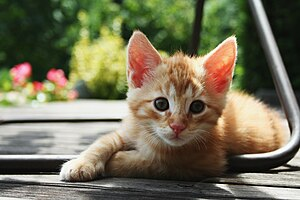

In [52]:
image_path = "image.jpg"
image = Image.open(image_path)#.convert("RGB")

image

In [ ]:
from functools import lru_cache


In [75]:
import typing

def hash_image(image):
    image = pic2int(image)
    image = Image.fromarray(image)
    image = image.resize((512, 512))
    image = image.convert("RGB")
    image = image.tobytes()
    return hash(image)

def hash_all(x):    
    if isinstance(x, typing.Hashable):
        print(type(x))
        return hash(x)
    
    if isinstance(x, typing.Union[list, tuple]):        
        return hash(sum(hash_all(i) for i in x))
    
    if isinstance(x, dict):
        return hash(sum(hash_all(v) for v in x.values()))
    
    if isinstance(x, np.ndarray):
        return hash(x.tobytes())
    
    if isinstance(x, torch.Tensor):
        return hash(x.cpu().detach().numpy().tobytes())
    
    if isinstance(x, Image.Image):
        return hash_image(x)
    
    return hash(str(x))


def memo(func):
    m = {}
    def wrapper(*arg, **kwarg):
        hash = hash_all((*arg, *kwarg.items()))
        if hash not in m:
            m[hash] = func(*arg, **kwarg)
        return m[hash]
    return wrapper

In [76]:
a = [image, pic2float(image), (image)]
hash_all(a)

-2110705807501759719